In [ ]:
pip install torch torchvision torchaudio ultralytics pillow pytesseract numpy opencv-python matplotlib
pip install scikit-learn matplotlib transformers 

In [1]:
check = [
    "check_signature_test_case/check/al_arafah_mehedy.jpeg",
    "check_signature_test_case/check/community_tareq.jpeg",
    "check_signature_test_case/check/ncc_anik.jpeg",
    "check_signature_test_case/check/bangla_check.jpeg",
    "check_signature_test_case/check/shawon_check.jpeg",
    "check_signature_test_case/check/shawon_demo.jpeg",
]

signatures = [
    "check_signature_test_case/signature/anik_1.jpeg",
    "check_signature_test_case/signature/anik_2.jpeg",
    "check_signature_test_case/signature/anik_forged.jpeg",
    "check_signature_test_case/signature/bangla_1.jpeg",
    "check_signature_test_case/signature/bangla_2.jpeg",
    "check_signature_test_case/signature/mehedy_1.jpeg",
    "check_signature_test_case/signature/mehedy_2.jpeg",
    "check_signature_test_case/signature/shawon_1.jpeg",
    "check_signature_test_case/signature/tareq_1.jpeg",
    "check_signature_test_case/signature/tareq_2.jpeg",
    "check_signature_test_case/signature/tareq_forged.jpeg",
]

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def isolate_signature(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold to binary image (signature in white, background in black)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create empty mask to draw filtered contours
    mask = np.zeros_like(binary)

    # Filter and draw only meaningful signature-like contours
    for cnt in contours:
        area = cv2.contourArea(cnt)
        x, y, w, h = cv2.boundingRect(cnt)

        # Filter conditions
        if area > 100 and w > 10 and h > 10:  # Skip tiny specks
            mask = cv2.drawContours(mask, [cnt], -1, 255, -1)  # Fill the contour

    # Final result (bitwise AND to extract the denoised signature)
    result = cv2.bitwise_and(binary, mask)

    return result

# Load model and image
def process_signature_image(image_path):
    model = YOLO("yolov8s.pt")
    image = cv2.imread(image_path)
    results = model(image)

    processed_images = []
    for i, box in enumerate(results[0].boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cropped = image[y1:y2, x1:x2]
        cleaned = isolate_signature(cropped)
        processed_images.append(cleaned)

    return processed_images  # List of processed images


In [11]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = AutoModel.from_pretrained("microsoft/resnet-50")

def extract_vector(image_array):
    image = Image.fromarray(cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB))
    inputs = processor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        features = model(**inputs).last_hidden_state  # shape: (1, 2048, 7, 7)
        pooled = torch.mean(features, dim=[2, 3])  # Global Average Pooling on H, W
        
    return pooled.squeeze()  # shape: (2048,)
    

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def get_similarity(check_signature, stored_signature):
    vec1 = extract_vector(check_signature)
    vec2 = extract_vector(stored_signature)
    similarity = cosine_similarity(vec1, vec2)
    return similarity


In [12]:
import matplotlib.pyplot as plt

def get_process_signature(check_path, signature_path):
    check_images = process_signature_image(check_path)
    stored_images = process_signature_image(signature_path)

    if not check_images or not stored_images:
        print("No signatures detected.")
        return

    check_signature = check_images[0]
    stored_signature = stored_images[0]

    similarity = get_similarity(check_signature, stored_signature)
    print("Cosine Similarity:", similarity)

    if similarity >= 0.91:
        print("Genuine Signature")
    else:
        print("Forged Signature")

    plot_signature(check_signature, stored_signature)


def plot_signature(check_signature, stored_signature):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(check_signature, cmap='gray')
    axs[0].set_title("Uploaded Signature")
    axs[0].axis('off')

    axs[1].imshow(stored_signature, cmap='gray')
    axs[1].set_title("Reference Signature")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()



0: 320x640 1 signature, 58.6ms
Speed: 1.8ms preprocess, 58.6ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 224x640 1 signature, 41.5ms
Speed: 1.2ms preprocess, 41.5ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Cosine Similarity: 0.7152256
Forged Signature


/var/folders/g0/wnct39_j5wd1n0m3zgztg5lh0000gn/T/ipykernel_32886/1131024961.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


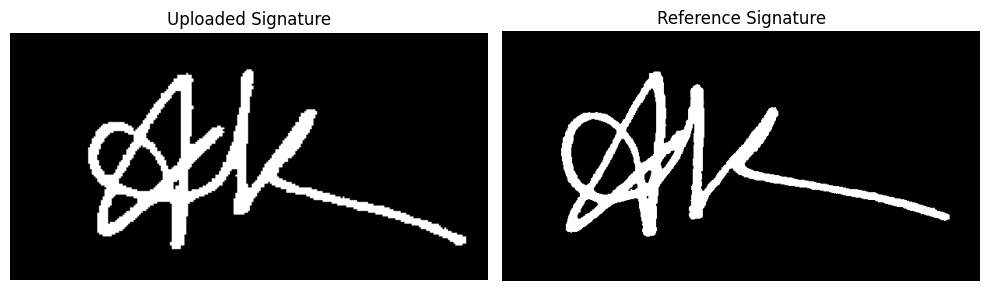

In [13]:
get_process_signature("check_signature_test_case/check/ncc_anik.jpeg", "check_signature_test_case/signature/anik_1.jpeg")

In [6]:
get_process_signature("check_signature_test_case/check/bangla_check.jpeg", "check_signature_test_case/signature/bangla_2.jpeg")


0: 320x640 (no detections), 69.5ms
Speed: 1.6ms preprocess, 69.5ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 640x640 1 signature, 126.7ms
Speed: 4.9ms preprocess, 126.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
No signatures detected.


In [14]:
def run_comparisons(index):
    if index < 1 or index > len(check):
        print("Invalid index: Please use a number between 1 and", len(check))
        return

    check_path = check[index - 1]
    print(f"Running comparisons for: {check_path}\n")

    for sig_path in signatures:
        print(f"Comparing with: {sig_path}")
        (get_process_signature(check_path, sig_path))
        print("-" * 140)


Running comparisons for: check_signature_test_case/check/al_arafah_mehedy.jpeg

Comparing with: check_signature_test_case/signature/anik_1.jpeg

0: 320x640 1 signature, 81.9ms
Speed: 2.1ms preprocess, 81.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 224x640 1 signature, 42.6ms
Speed: 1.0ms preprocess, 42.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Cosine Similarity: 0.641587
Forged Signature


/var/folders/g0/wnct39_j5wd1n0m3zgztg5lh0000gn/T/ipykernel_32886/1131024961.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


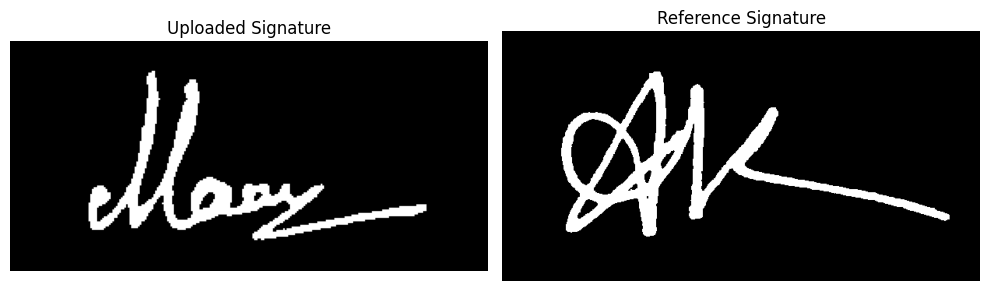

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/anik_2.jpeg

0: 320x640 1 signature, 75.0ms
Speed: 1.9ms preprocess, 75.0ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 256x640 1 signature, 62.4ms
Speed: 1.5ms preprocess, 62.4ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)
Cosine Similarity: 0.59529185
Forged Signature


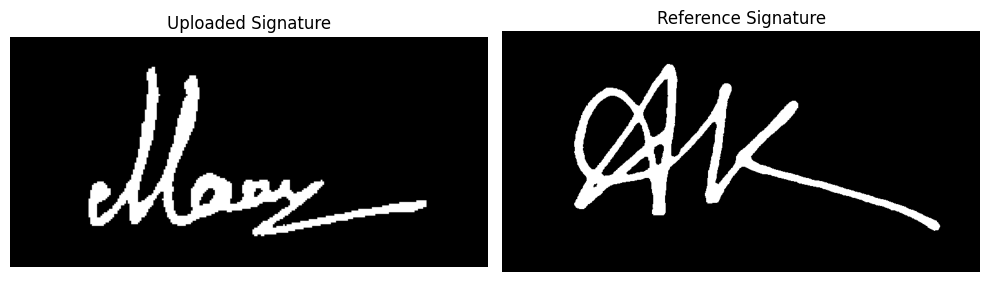

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/anik_forged.jpeg

0: 320x640 1 signature, 65.5ms
Speed: 1.7ms preprocess, 65.5ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 416x640 1 signature, 100.8ms
Speed: 1.5ms preprocess, 100.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Cosine Similarity: 0.41086975
Forged Signature


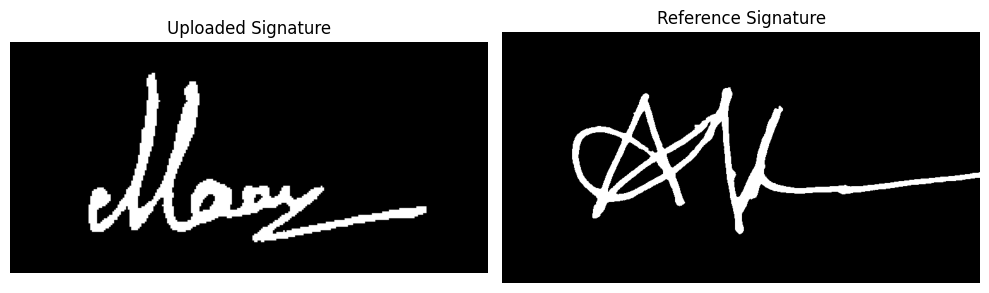

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/bangla_1.jpeg

0: 320x640 1 signature, 65.3ms
Speed: 1.6ms preprocess, 65.3ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 576x640 1 signature, 108.4ms
Speed: 3.2ms preprocess, 108.4ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)
Cosine Similarity: 0.65082365
Forged Signature


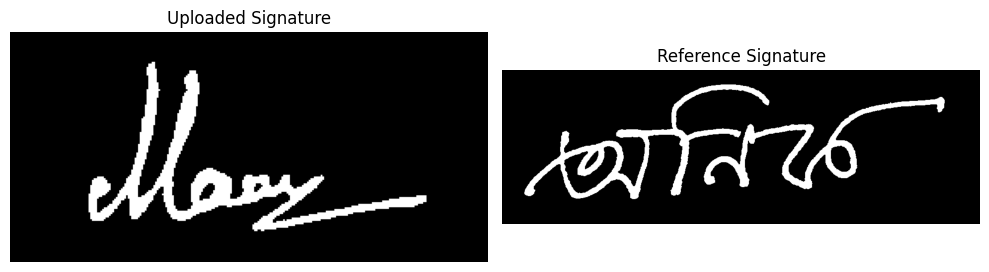

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/bangla_2.jpeg

0: 320x640 1 signature, 77.0ms
Speed: 1.6ms preprocess, 77.0ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 640x640 1 signature, 123.4ms
Speed: 3.0ms preprocess, 123.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.5700424
Forged Signature


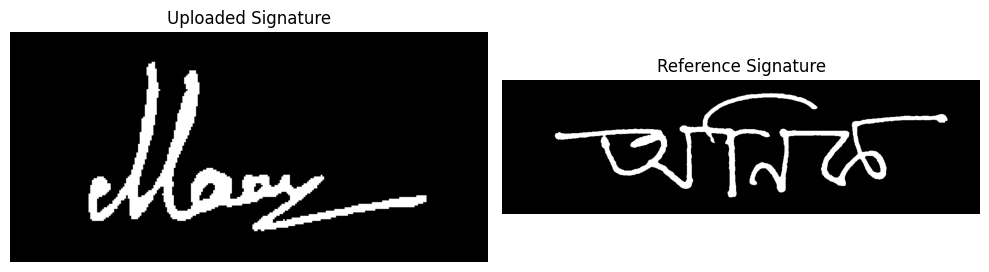

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/mehedy_1.jpeg

0: 320x640 1 signature, 77.9ms
Speed: 1.6ms preprocess, 77.9ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)

0: 640x640 1 signature, 133.4ms
Speed: 3.4ms preprocess, 133.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.68877417
Forged Signature


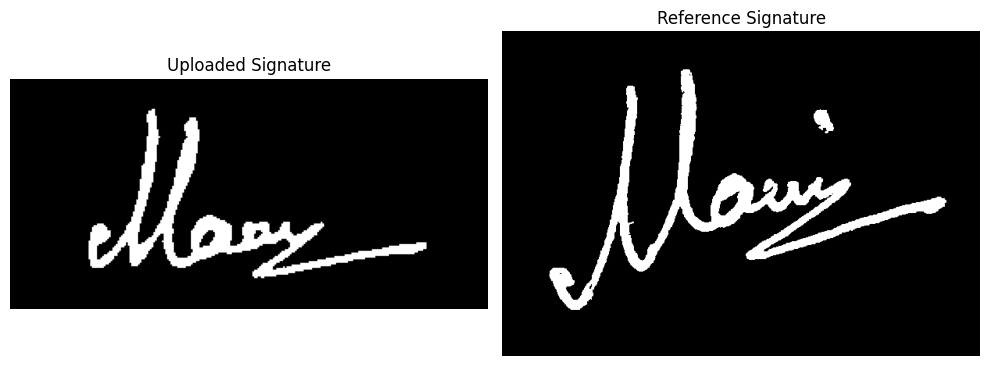

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/mehedy_2.jpeg

0: 320x640 1 signature, 63.2ms
Speed: 1.5ms preprocess, 63.2ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 640x640 1 signature, 154.6ms
Speed: 3.3ms preprocess, 154.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.6478805
Forged Signature


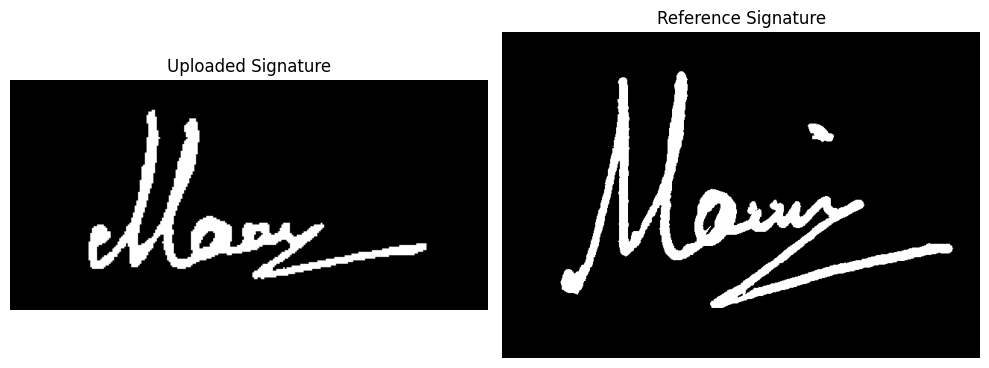

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/tareq_1.jpeg

0: 320x640 1 signature, 77.5ms
Speed: 1.5ms preprocess, 77.5ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 640x576 1 signature, 101.4ms
Speed: 2.2ms preprocess, 101.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)
Cosine Similarity: 0.60791904
Forged Signature


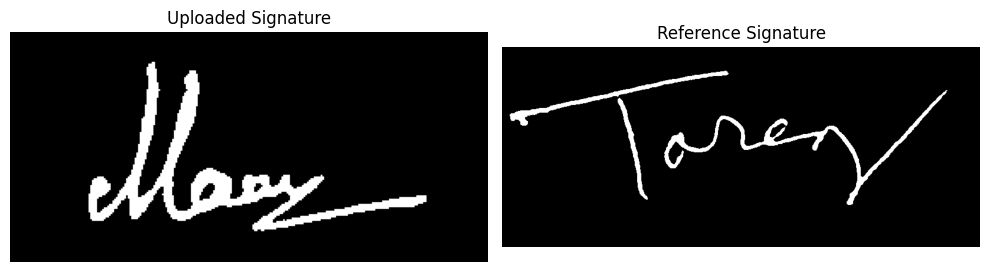

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/tareq_2.jpeg

0: 320x640 1 signature, 64.9ms
Speed: 1.6ms preprocess, 64.9ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 416x640 1 signature, 86.8ms
Speed: 1.7ms preprocess, 86.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)
Cosine Similarity: 0.48014796
Forged Signature


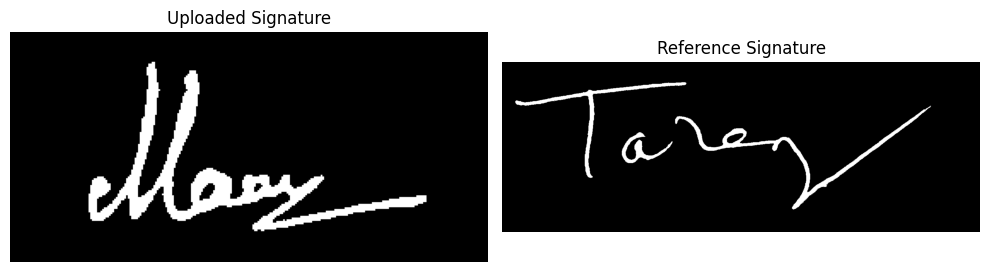

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/tareq_forged.jpeg

0: 320x640 1 signature, 96.2ms
Speed: 2.5ms preprocess, 96.2ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 448x640 1 signature, 106.3ms
Speed: 1.9ms preprocess, 106.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Cosine Similarity: 0.47491714
Forged Signature


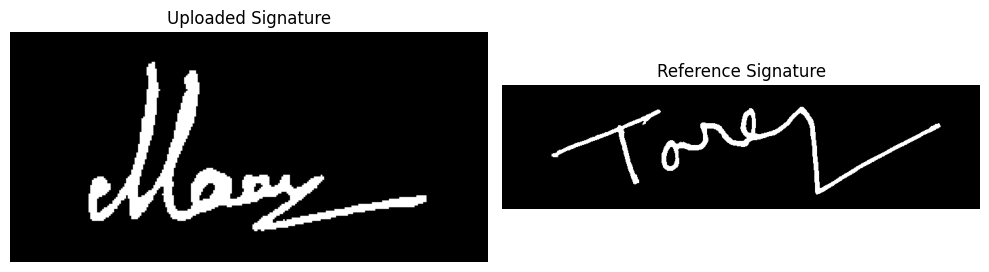

--------------------------------------------------------------------------------------------------------------------------------------------


In [19]:
run_comparisons(1)

Running comparisons for: check_signature_test_case/check/community_tareq.jpeg

Comparing with: check_signature_test_case/signature/anik_1.jpeg

0: 288x640 1 signature, 118.7ms
Speed: 2.4ms preprocess, 118.7ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 signature, 47.2ms
Speed: 1.2ms preprocess, 47.2ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Cosine Similarity: 0.6827812
Forged Signature


/var/folders/g0/wnct39_j5wd1n0m3zgztg5lh0000gn/T/ipykernel_32886/1131024961.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


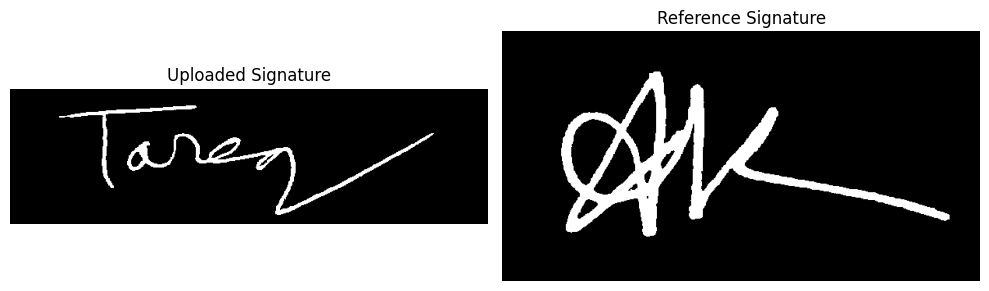

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/anik_2.jpeg

0: 288x640 1 signature, 58.8ms
Speed: 1.6ms preprocess, 58.8ms inference, 0.4ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 signature, 53.7ms
Speed: 1.6ms preprocess, 53.7ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)
Cosine Similarity: 0.66192603
Forged Signature


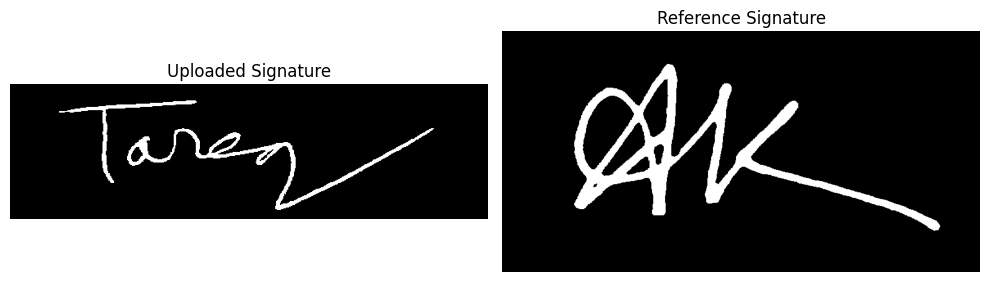

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/anik_forged.jpeg

0: 288x640 1 signature, 62.2ms
Speed: 1.5ms preprocess, 62.2ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)

0: 416x640 1 signature, 91.4ms
Speed: 1.6ms preprocess, 91.4ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)
Cosine Similarity: 0.54278356
Forged Signature


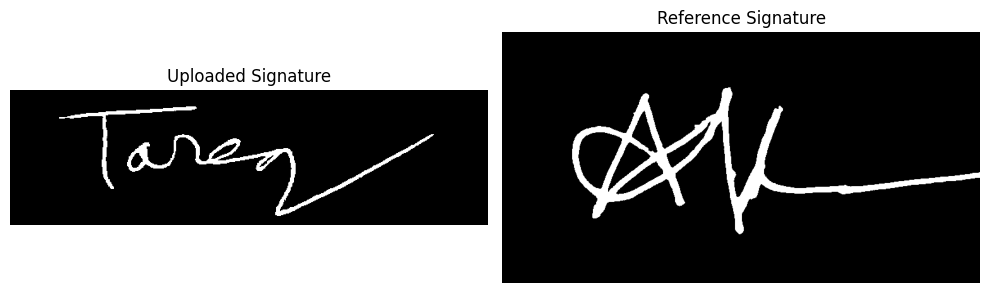

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/bangla_1.jpeg

0: 288x640 1 signature, 69.3ms
Speed: 1.5ms preprocess, 69.3ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)

0: 576x640 1 signature, 133.7ms
Speed: 2.8ms preprocess, 133.7ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)
Cosine Similarity: 0.8028747
Forged Signature


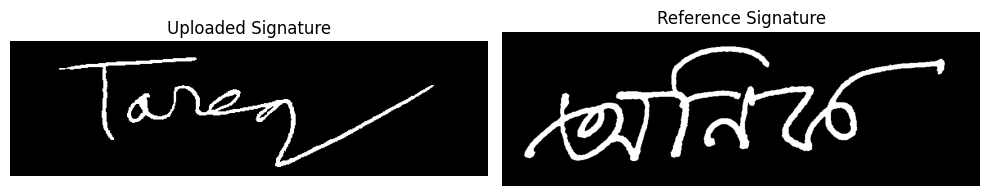

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/bangla_2.jpeg

0: 288x640 1 signature, 55.1ms
Speed: 1.5ms preprocess, 55.1ms inference, 0.6ms postprocess per image at shape (1, 3, 288, 640)

0: 640x640 1 signature, 125.0ms
Speed: 2.9ms preprocess, 125.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.6525563
Forged Signature


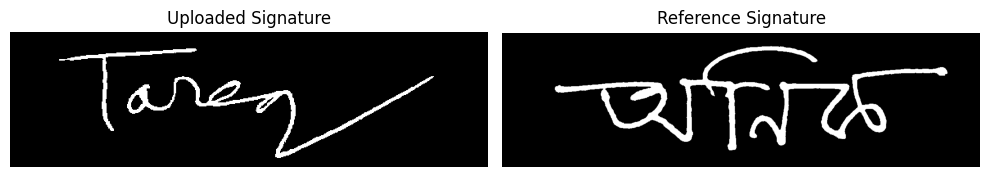

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/mehedy_1.jpeg

0: 288x640 1 signature, 54.7ms
Speed: 1.5ms preprocess, 54.7ms inference, 0.4ms postprocess per image at shape (1, 3, 288, 640)

0: 640x640 1 signature, 155.7ms
Speed: 3.3ms preprocess, 155.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.76330143
Forged Signature


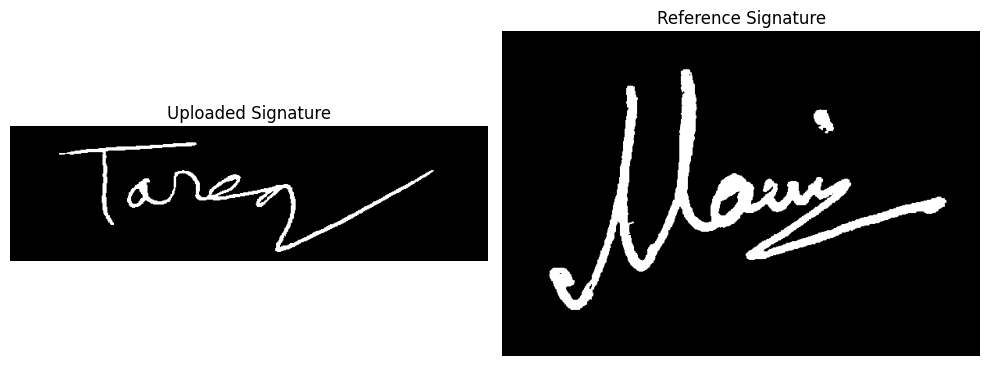

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/mehedy_2.jpeg

0: 288x640 1 signature, 90.0ms
Speed: 1.8ms preprocess, 90.0ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)

0: 640x640 1 signature, 113.3ms
Speed: 3.0ms preprocess, 113.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.67432445
Forged Signature


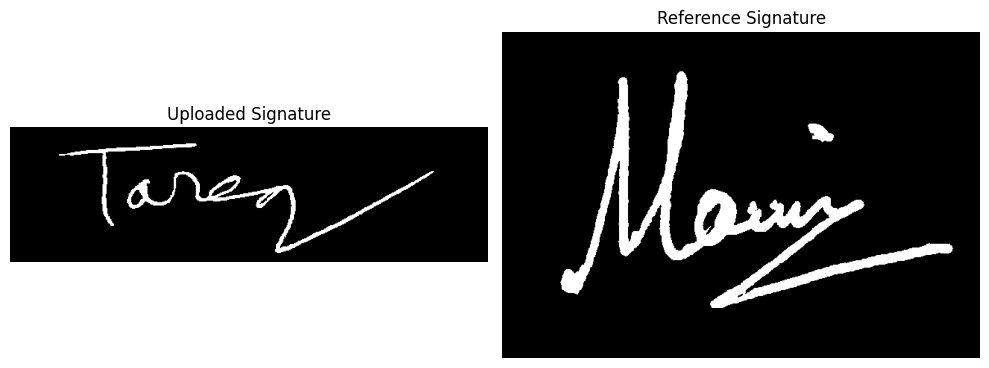

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/tareq_1.jpeg

0: 288x640 1 signature, 57.5ms
Speed: 1.2ms preprocess, 57.5ms inference, 0.4ms postprocess per image at shape (1, 3, 288, 640)

0: 640x576 1 signature, 98.5ms
Speed: 2.3ms preprocess, 98.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 576)
Cosine Similarity: 0.7565121
Forged Signature


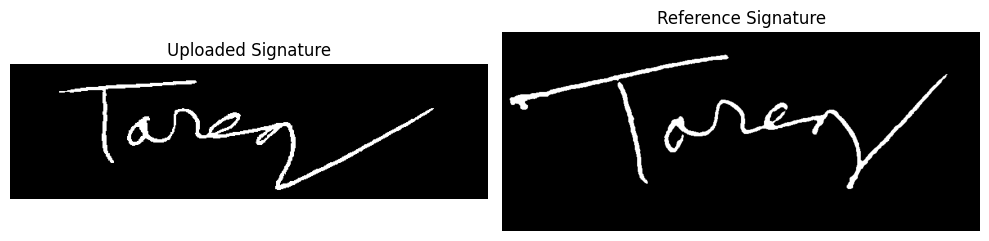

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/tareq_2.jpeg

0: 288x640 1 signature, 60.3ms
Speed: 1.3ms preprocess, 60.3ms inference, 0.4ms postprocess per image at shape (1, 3, 288, 640)

0: 416x640 1 signature, 75.3ms
Speed: 2.0ms preprocess, 75.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)
Cosine Similarity: 0.7264016
Forged Signature


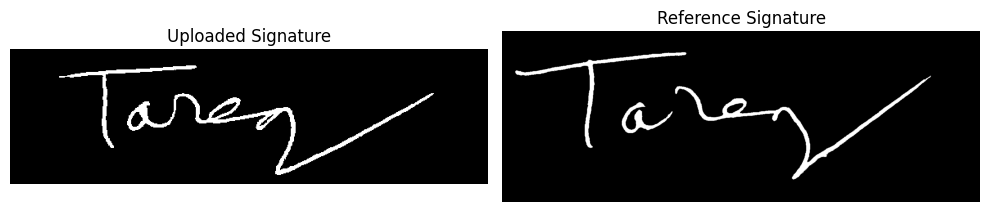

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/tareq_forged.jpeg

0: 288x640 1 signature, 56.4ms
Speed: 1.9ms preprocess, 56.4ms inference, 0.4ms postprocess per image at shape (1, 3, 288, 640)

0: 448x640 1 signature, 77.1ms
Speed: 1.6ms preprocess, 77.1ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)
Cosine Similarity: 0.71865034
Forged Signature


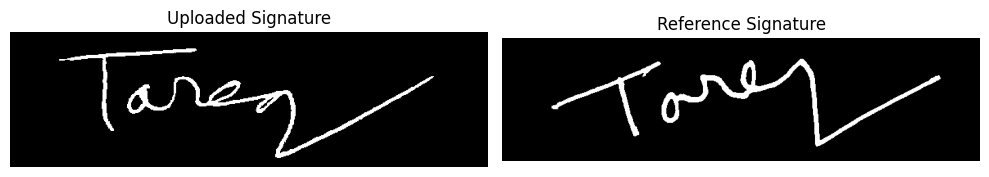

--------------------------------------------------------------------------------------------------------------------------------------------


In [20]:
run_comparisons(2)

Running comparisons for: check_signature_test_case/check/ncc_anik.jpeg

Comparing with: check_signature_test_case/signature/anik_1.jpeg

0: 320x640 1 signature, 61.4ms
Speed: 5.2ms preprocess, 61.4ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)

0: 224x640 1 signature, 35.6ms
Speed: 1.2ms preprocess, 35.6ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Cosine Similarity: 0.7152256
Forged Signature


/var/folders/g0/wnct39_j5wd1n0m3zgztg5lh0000gn/T/ipykernel_32886/1131024961.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


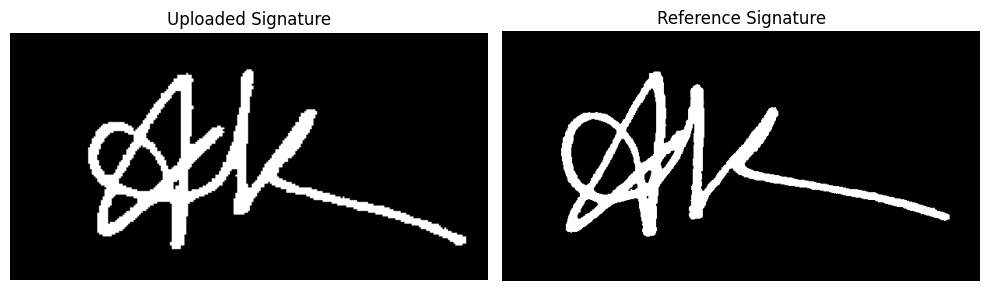

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/anik_2.jpeg

0: 320x640 1 signature, 60.9ms
Speed: 1.8ms preprocess, 60.9ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 256x640 1 signature, 49.0ms
Speed: 1.7ms preprocess, 49.0ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)
Cosine Similarity: 0.6144967
Forged Signature


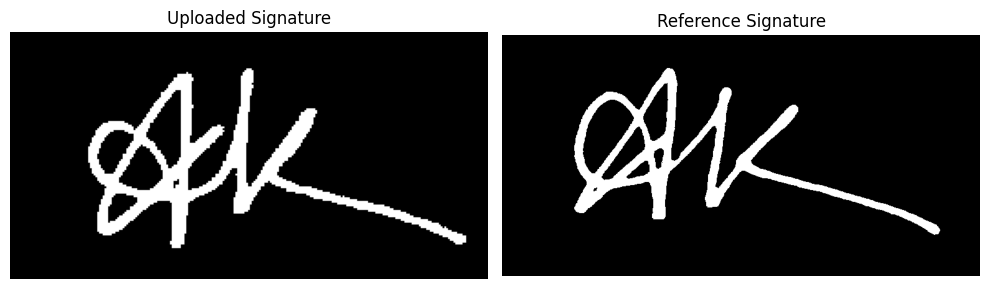

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/bangla_1.jpeg

0: 320x640 1 signature, 64.3ms
Speed: 1.6ms preprocess, 64.3ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 576x640 1 signature, 127.2ms
Speed: 3.4ms preprocess, 127.2ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)
Cosine Similarity: 0.5447118
Forged Signature


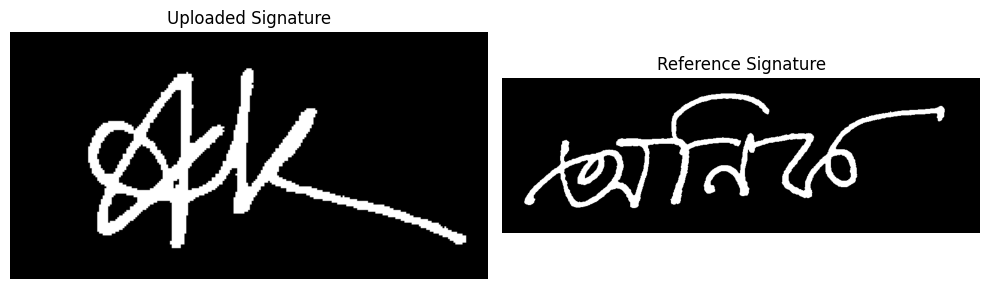

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/bangla_2.jpeg

0: 320x640 1 signature, 66.4ms
Speed: 1.8ms preprocess, 66.4ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 640x640 1 signature, 111.5ms
Speed: 3.1ms preprocess, 111.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.5692746
Forged Signature


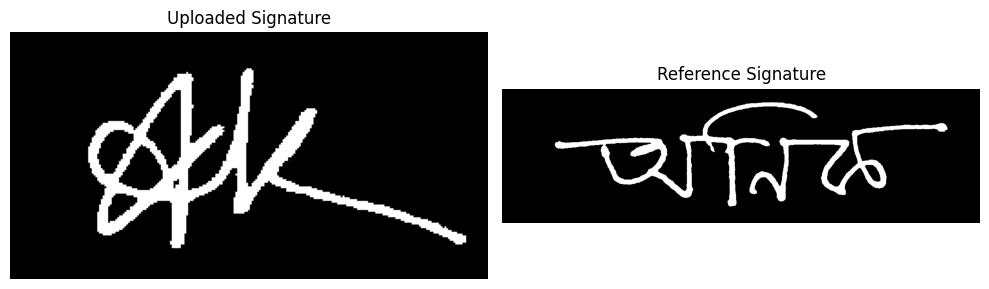

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/mehedy_1.jpeg

0: 320x640 1 signature, 66.3ms
Speed: 1.6ms preprocess, 66.3ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 640x640 1 signature, 117.3ms
Speed: 2.8ms preprocess, 117.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.4655798
Forged Signature


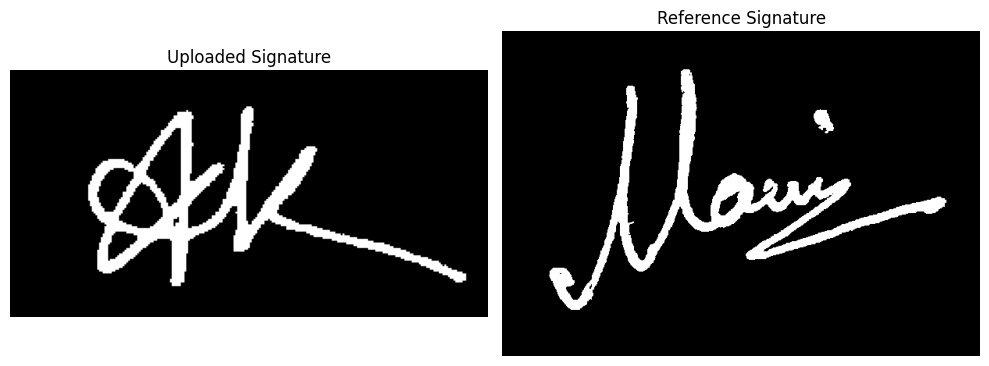

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/mehedy_2.jpeg

0: 320x640 1 signature, 77.9ms
Speed: 1.7ms preprocess, 77.9ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)

0: 640x640 1 signature, 95.4ms
Speed: 3.2ms preprocess, 95.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.5215459
Forged Signature


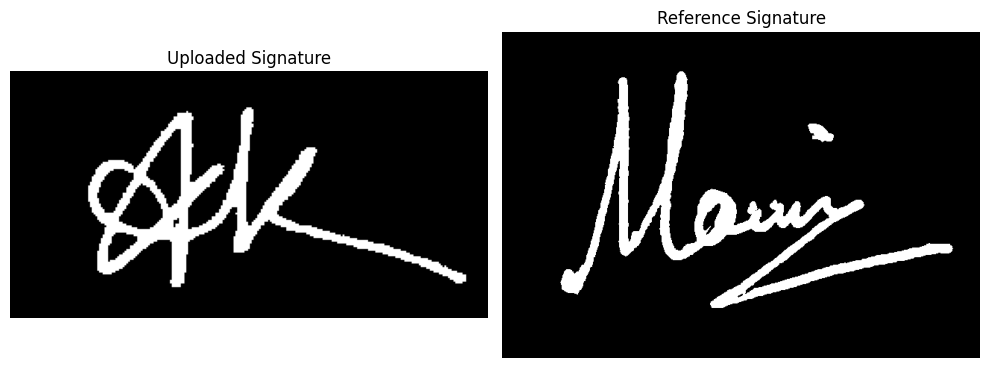

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/tareq_1.jpeg

0: 320x640 1 signature, 64.1ms
Speed: 1.6ms preprocess, 64.1ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 640x576 1 signature, 112.2ms
Speed: 2.8ms preprocess, 112.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 576)
Cosine Similarity: 0.48216644
Forged Signature


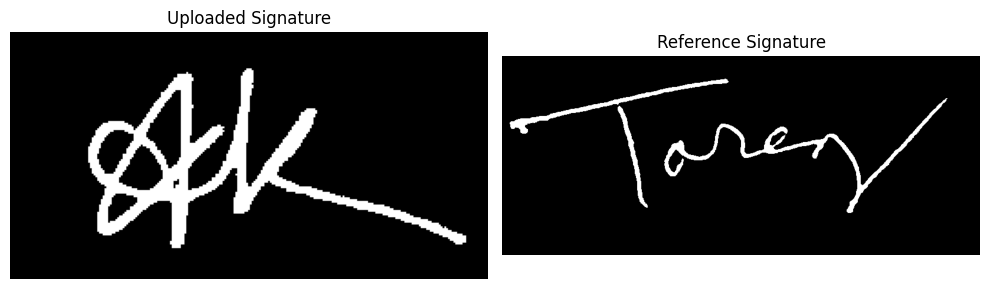

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/tareq_2.jpeg

0: 320x640 1 signature, 86.5ms
Speed: 2.2ms preprocess, 86.5ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)

0: 416x640 1 signature, 90.6ms
Speed: 2.2ms preprocess, 90.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Cosine Similarity: 0.3964572
Forged Signature


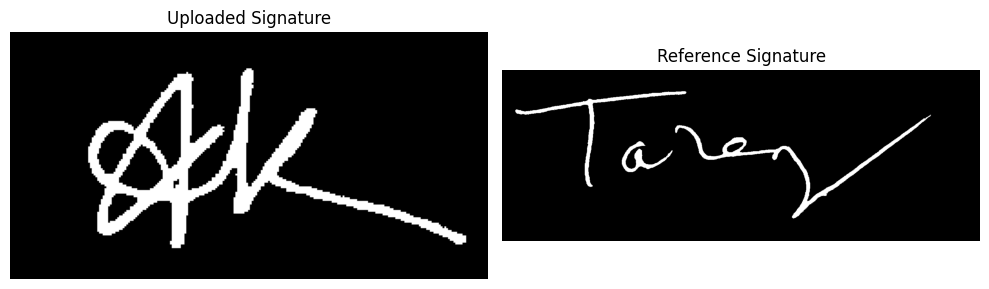

--------------------------------------------------------------------------------------------------------------------------------------------


In [8]:
run_comparisons(3)

Running comparisons for: check_signature_test_case/check/ncc_anik.jpeg

Comparing with: check_signature_test_case/signature/anik_1.jpeg

0: 320x640 1 signature, 120.2ms
Speed: 2.1ms preprocess, 120.2ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 224x640 1 signature, 36.1ms
Speed: 1.1ms preprocess, 36.1ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)
Cosine Similarity: 0.7152256
Forged Signature


/var/folders/g0/wnct39_j5wd1n0m3zgztg5lh0000gn/T/ipykernel_29931/1131024961.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


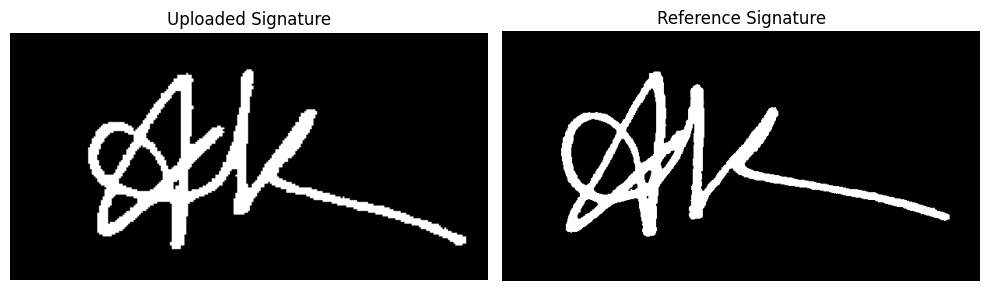

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/anik_2.jpeg

0: 320x640 1 signature, 61.2ms
Speed: 1.4ms preprocess, 61.2ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 256x640 1 signature, 46.4ms
Speed: 1.1ms preprocess, 46.4ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 640)
Cosine Similarity: 0.6144967
Forged Signature


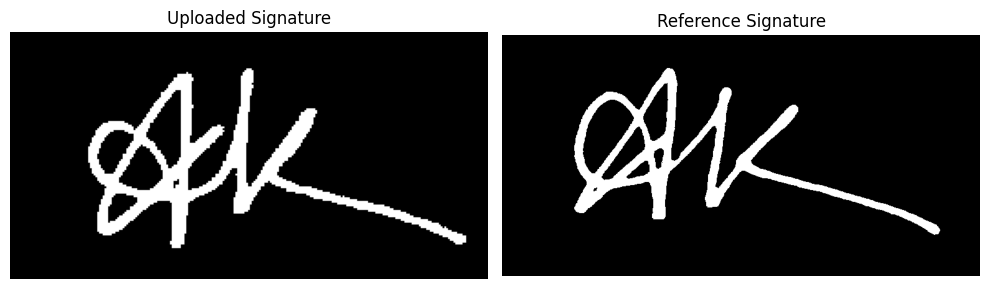

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/bangla_1.jpeg

0: 320x640 1 signature, 99.8ms
Speed: 1.8ms preprocess, 99.8ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 576x640 1 signature, 123.6ms
Speed: 3.0ms preprocess, 123.6ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)
Cosine Similarity: 0.5447118
Forged Signature


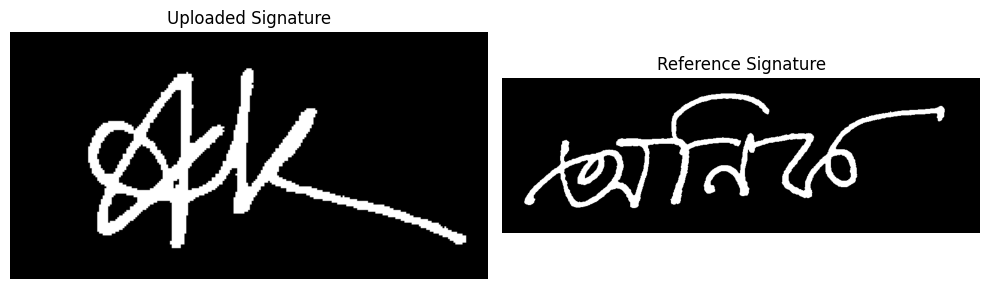

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/bangla_2.jpeg

0: 320x640 1 signature, 97.9ms
Speed: 1.7ms preprocess, 97.9ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 640x640 1 signature, 152.2ms
Speed: 3.1ms preprocess, 152.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.5692746
Forged Signature


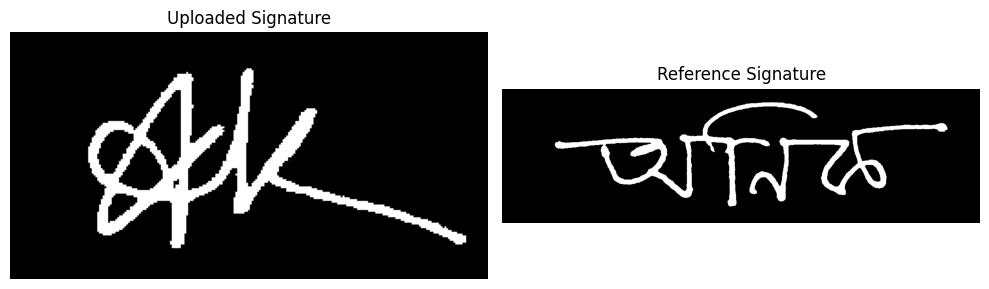

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/mehedy_1.jpeg

0: 320x640 1 signature, 91.9ms
Speed: 1.8ms preprocess, 91.9ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 640x640 1 signature, 139.2ms
Speed: 5.8ms preprocess, 139.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.4655798
Forged Signature


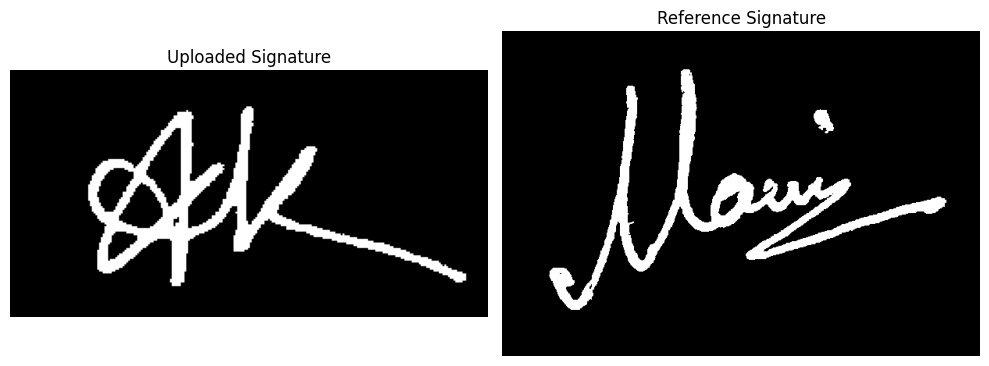

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/mehedy_2.jpeg

0: 320x640 1 signature, 70.5ms
Speed: 1.8ms preprocess, 70.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 640x640 1 signature, 120.3ms
Speed: 3.2ms preprocess, 120.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Cosine Similarity: 0.5215459
Forged Signature


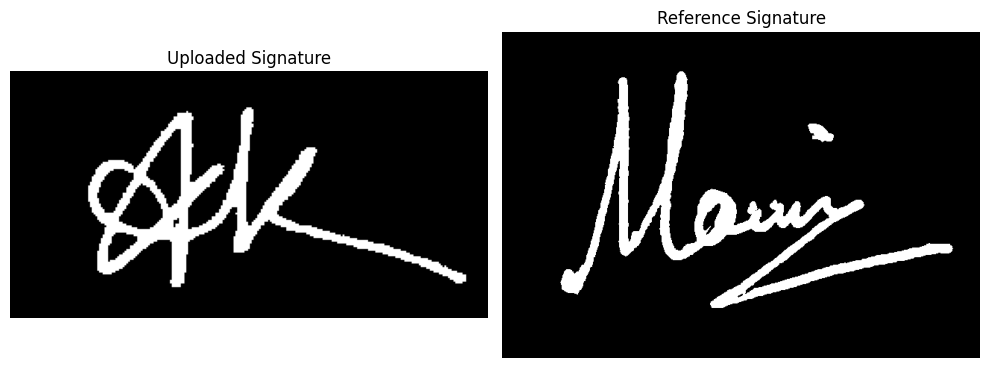

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/tareq_1.jpeg

0: 320x640 1 signature, 72.3ms
Speed: 1.4ms preprocess, 72.3ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 640x576 1 signature, 94.6ms
Speed: 2.6ms preprocess, 94.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 576)
Cosine Similarity: 0.48216644
Forged Signature


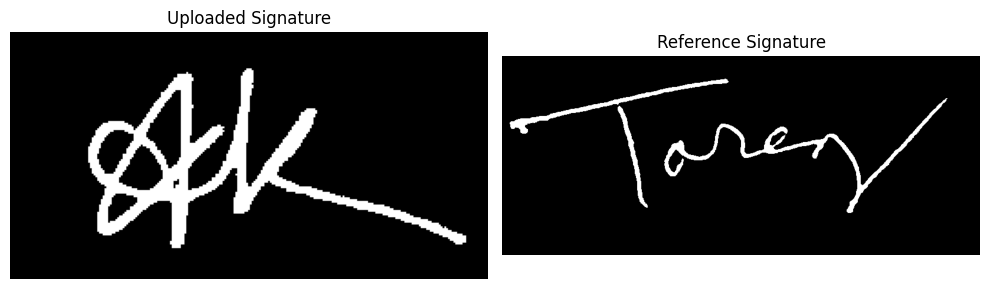

--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/tareq_2.jpeg

0: 320x640 1 signature, 59.5ms
Speed: 1.3ms preprocess, 59.5ms inference, 0.4ms postprocess per image at shape (1, 3, 320, 640)

0: 416x640 1 signature, 80.9ms
Speed: 2.4ms preprocess, 80.9ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)
Cosine Similarity: 0.3964572
Forged Signature


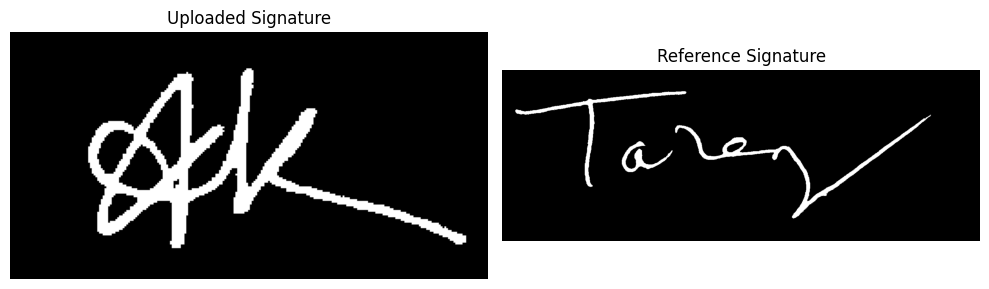

--------------------------------------------------------------------------------------------------------------------------------------------


In [11]:
run_comparisons(3)

In [16]:
run_comparisons(4)

Running comparisons for: check_signature_test_case/check/bangla_check.jpeg

Comparing with: check_signature_test_case/signature/anik_1.jpeg

0: 320x640 (no detections), 66.2ms
Speed: 2.0ms preprocess, 66.2ms inference, 0.3ms postprocess per image at shape (1, 3, 320, 640)

0: 224x640 1 signature, 40.6ms
Speed: 1.2ms preprocess, 40.6ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 640)
No signatures detected.
--------------------------------------------------------------------------------------------------------------------------------------------
Comparing with: check_signature_test_case/signature/anik_2.jpeg

0: 320x640 (no detections), 67.7ms
Speed: 1.6ms preprocess, 67.7ms inference, 0.2ms postprocess per image at shape (1, 3, 320, 640)

0: 256x640 1 signature, 56.5ms
Speed: 1.3ms preprocess, 56.5ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)
No signatures detected.
-----------------------------------------------------------------------------------

In [51]:
run_comparisons(5)

Invalid index: Please use a number between 1 and 4
